### separate on RTG/RTO/NEW and PlanType, yield curve for x=installmentNumber

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/Users/starsrain/2025_concord/yieldCurve_augmenting/raw_data/1029_uwb_amdv1.csv')

In [2]:
def compute_daily_yield(data):
    """
    Compute daily cumulative yield correctly:
    1. Get unique loans and their original amounts (avoid double counting)
    2. For each day since origination, sum all payments made up to that day
    3. Calculate yield as cumulative_payments / total_originated_amount
    """
    if data.empty:
        return pd.Series(dtype=float)
    
    # Get unique loans and their amounts (avoid double counting from multiple installments)
    loan_amounts = data.groupby('LoanID')['OriginatedAmount'].first()
    total_originated = loan_amounts.sum()
    
    # Group by Days_Since_Orig and sum payments for each day
    daily_payments = data.groupby('Days_Since_Orig')['PaidOffPaymentAmount'].sum()
    
    # Create cumulative sum of payments
    cumulative_payments = daily_payments.cumsum()
    
    # Calculate yield as cumulative payments / total originated
    yield_curve = cumulative_payments / total_originated
    
    return yield_curve

def prepare_df_strict(df):
    """Prepare dataframe with strict data cleaning"""
    df = df.copy()
    df = df[df['PaymentStatus'] != 'R']
    # Convert date columns
    date_cols = ['OriginationDate', 'DueDate']
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Drop rows with missing critical fields
    critical_fields = ['LoanID', 'OriginatedAmount', 'InstallmentNumber']
    initial_count = len(df)
    df = df.dropna(subset=critical_fields)
    dropped = initial_count - len(df)
    if dropped > 0:
        print(f"[prepare] Dropped {dropped} rows with missing critical fields")

    
    # Create cohort from origination date
    df['Cohort'] = df['OriginationDate'].dt.to_period('M').astype(str)
    
    # Ensure CustType exists
    if 'CustType' not in df.columns:
        df['CustType'] = 'Unknown'
    before_dedup = len(df)
    df = df.drop_duplicates(subset=['LoanID', 'InstallmentNumber', 'DueDate', 'PaidOffPaymentAmount'])
    after_dedup = len(df)
    if before_dedup != after_dedup:
        print(f"[prepare] Removed {before_dedup - after_dedup} duplicate records")

    
    return df

Step 1: Cleaning data...
[prepare] Removed 200 duplicate records
Step 2: Filtering DueDate <= 2025-10-28
Kept 35,898/36,416 records with DueDate <= today
Final dataset: 4,559 records, 915 unique loans
Found PlanTypes: ['Default', 'FlatPay']
Found CustTypes: ['NEW', 'RTG', 'RTO']
Using PlanTypes: ['Default', 'FlatPay']
Using CustTypes: ['NEW', 'RTG', 'RTO']

Payin Ratios by InstallmentNumber for months: 2025-02

DEFAULT PLAN:
----------------------------------------
  NEW | 2025-02 | loans=209 | I1=0.383, I6=0.367, I12=0.168, I18=0.063
  RTG | 2025-02 | loans=398 | I1=0.571, I6=0.380, I12=0.158, I18=0.051
  RTO | 2025-02 | loans=25 | I1=0.426, I6=0.330, I12=0.181


C:\Users\axu\AppData\Local\Temp\ipykernel_31256\2626986755.py:118: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['InstallmentPayinRatio'], weights=x['OriginatedAmount']))
C:\Users\axu\AppData\Local\Temp\ipykernel_31256\2626986755.py:118: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['InstallmentPayinRatio'], weights=x['OriginatedAmount']))
C:\Users\axu\AppDa


FLATPAY PLAN:
----------------------------------------
  NEW | 2025-02 | loans=223 | I1=0.313, I6=0.301, I12=0.229, I18=0.158, I24=0.052
  RTG | 2025-02 | loans=56 | I1=0.326, I6=0.238, I12=0.219, I18=0.156, I24=0.153
  RTO | 2025-02 | loans=4 | I1=0.327, I6=0.258


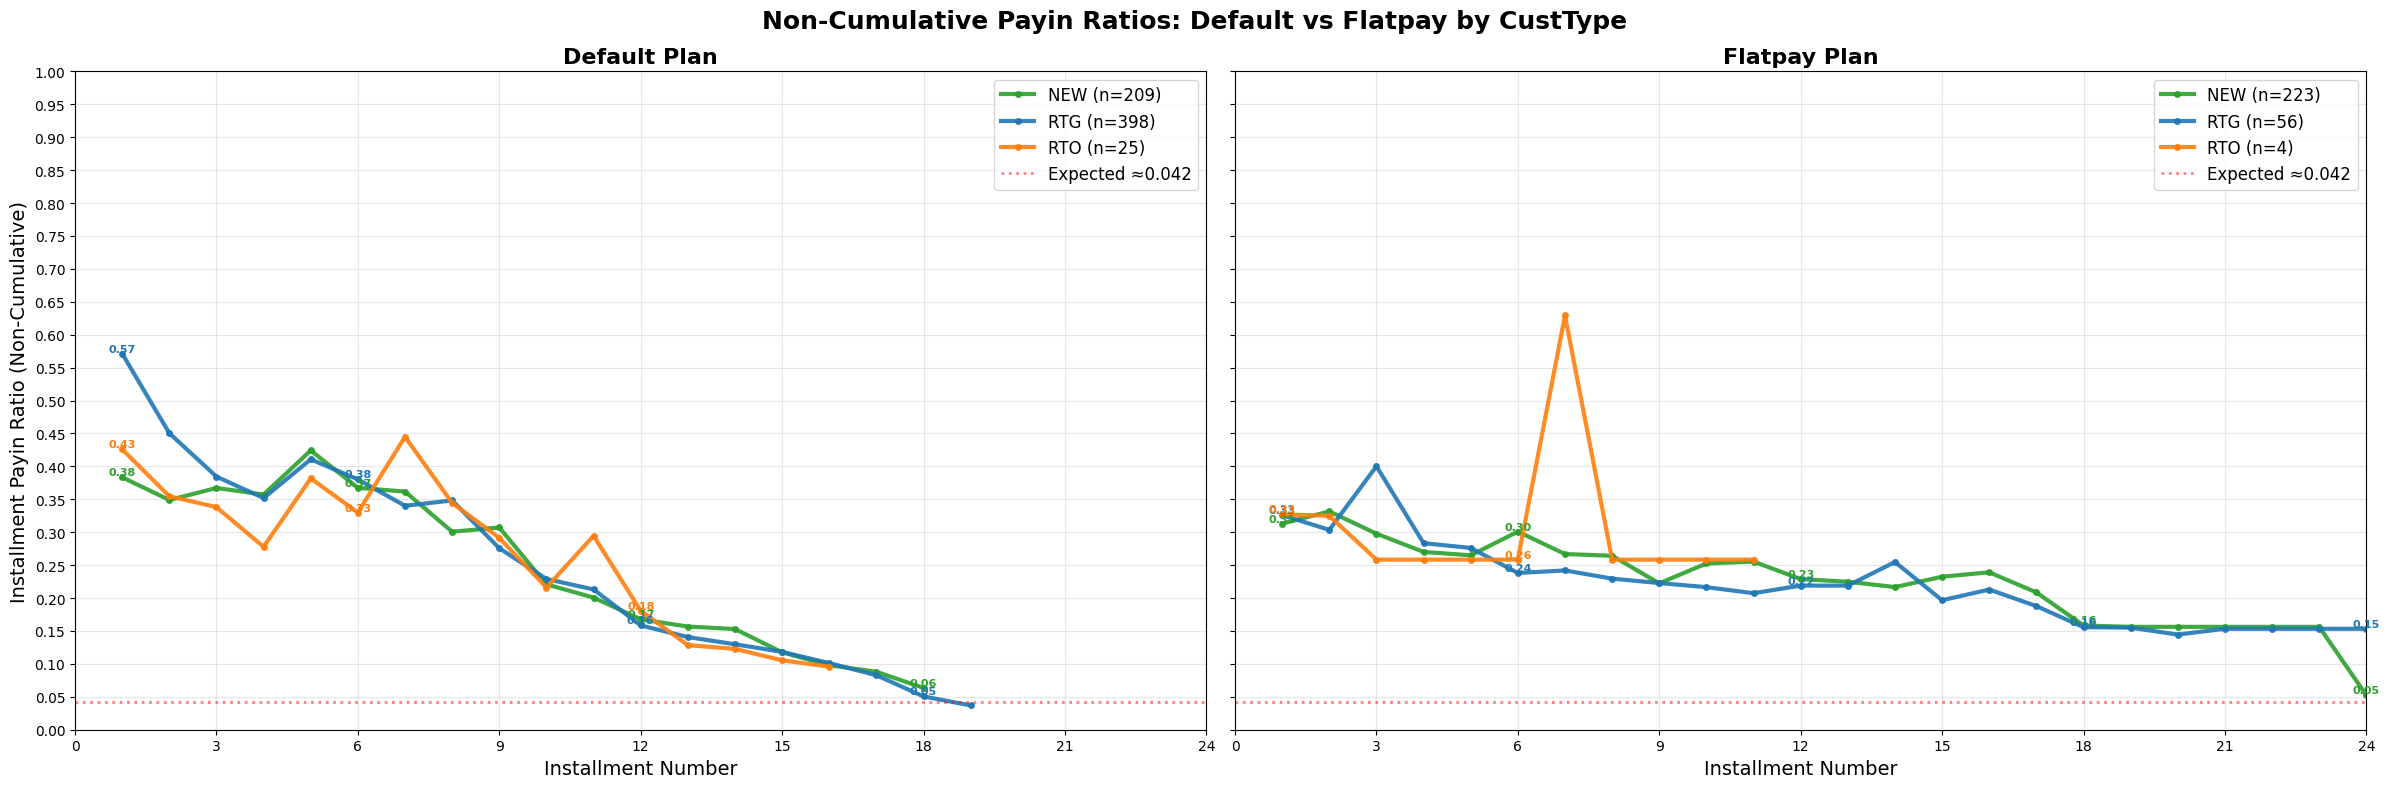

In [3]:
# Side-by-side plots: PlanType subplots with CustType lines
def plot_plantype_subplots_custtype_lines(data, months, max_installments=24, key_installments=None):
    """
    Plot non-cumulative payin ratios with two side-by-side subplots:
    - Left subplot: Default PlanType with 3 lines (NEW, RTG, RTO)
    - Right subplot: FlatPay PlanType with 3 lines (NEW, RTG, RTO)
    1. Apply proper data cleaning (remove 'R' status, deduplicate, etc.)
    2. Filter DueDate <= today
    3. Calculate non-cumulative payin ratio for each installment
    """
    
    if key_installments is None:
        key_installments = [1, 2, 3, 6, 12, 15, 18, 21, 24]
    
    # Step 1: Apply proper data cleaning using existing function
    print("Step 1: Cleaning data...")
    df_cleaned = prepare_df_strict(data)
    
    # Step 2: Filter out loans with DueDate > today
    today = pd.Timestamp.now().normalize()
    print(f"Step 2: Filtering DueDate <= {today.date()}")
    
    initial_count = len(df_cleaned)
    df_filtered = df_cleaned[df_cleaned['DueDate'] <= today].copy()
    print(f"Kept {len(df_filtered):,}/{initial_count:,} records with DueDate <= today")
    
    # Step 3: Filter to requested origination months
    df_filtered = df_filtered[df_filtered['Cohort'].isin(months)]
    
    # Step 4: Remove any rows with missing critical data for installment calculation
    df_filtered = df_filtered.dropna(subset=['LoanID', 'OriginatedAmount', 'PaidOffPaymentAmount', 'InstallmentNumber', 'PlanType', 'CustType'])
    
    print(f"Final dataset: {len(df_filtered):,} records, {df_filtered['LoanID'].nunique():,} unique loans")
    
    # Get unique PlanTypes and CustTypes
    unique_plantypes = sorted(df_filtered['PlanType'].unique())
    unique_custtypes = sorted(df_filtered['CustType'].unique())
    print(f"Found PlanTypes: {unique_plantypes}")
    print(f"Found CustTypes: {unique_custtypes}")
    
    # Define target PlanTypes and CustTypes
    target_plantypes = ['default', 'flatpay']
    target_custtypes = ['NEW', 'RTG', 'RTO']
    
    # Filter to only available ones, fallback to any available if targets not found
    available_plantypes = [pt for pt in target_plantypes if pt in unique_plantypes]
    if len(available_plantypes) == 0:
        # If target plan types not found, use first 2 available or all if less than 2
        available_plantypes = unique_plantypes[:2] if len(unique_plantypes) >= 2 else unique_plantypes
        print(f"Warning: Target PlanTypes {target_plantypes} not found. Using: {available_plantypes}")
    
    available_custtypes = [ct for ct in target_custtypes if ct in unique_custtypes]
    if len(available_custtypes) == 0:
        # If target customer types not found, use all available
        available_custtypes = unique_custtypes
        print(f"Warning: Target CustTypes {target_custtypes} not found. Using: {available_custtypes}")
    
    print(f"Using PlanTypes: {available_plantypes}")
    print(f"Using CustTypes: {available_custtypes}")
    
    # Handle case where no plan types are available
    if len(available_plantypes) == 0:
        print("Error: No PlanTypes found in data!")
        return {}
    
    # Color scheme for CustTypes (expand to handle more customer types)
    color_palette = ['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728', '#9467bd', '#8c564b']
    custtype_colors = {ct: color_palette[i % len(color_palette)] for i, ct in enumerate(available_custtypes)}
    
    curves = {}
    
    print(f"\nPayin Ratios by InstallmentNumber for months: {', '.join(months)}")
    print('='*90)
    
    # Create figure with side-by-side subplots
    fig, axes = plt.subplots(1, len(available_plantypes), figsize=(12*len(available_plantypes), 8), sharey=True)
    if len(available_plantypes) == 1:
        axes = [axes]
    
    for ax_idx, plantype in enumerate(available_plantypes):
        ax = axes[ax_idx]
        ax.set_title(f"{plantype.title()} Plan", fontsize=16, fontweight='bold')
        ax.set_xlabel('Installment Number', fontsize=14)
        if ax_idx == 0:
            ax.set_ylabel('Installment Payin Ratio (Non-Cumulative)', fontsize=14)
        ax.grid(True, alpha=0.3)
        
        print(f"\n{plantype.upper()} PLAN:")
        print('-' * 40)
        
        plantype_has_data = False
        
        for cust_type in available_custtypes:
            for month in months:
                # Filter for this month, customer type, and plan type
                subset = df_filtered[
                    (df_filtered['Cohort'] == month) & 
                    (df_filtered['PlanType'] == plantype) &
                    (df_filtered['CustType'] == cust_type)
                ].copy()
                
                if subset.empty:
                    continue
                    
                loan_count = subset['LoanID'].nunique()
                plantype_has_data = True
                
                # Calculate NON-CUMULATIVE payin ratio by installment
                per_installment = (subset.groupby(['LoanID', 'InstallmentNumber'], as_index=False)
                                 .agg(PaidThisInstallment=('PaidOffPaymentAmount', 'sum'),
                                      OriginatedAmount=('OriginatedAmount', 'first')))
                
                # Calculate non-cumulative payin ratio (payment for this installment only)
                per_installment['InstallmentPayinRatio'] = (per_installment['PaidThisInstallment'] / per_installment['OriginatedAmount']).clip(upper=1.0)
                
                # Calculate weighted average payin ratio by installment (NON-CUMULATIVE)
                installment_curve = (per_installment.groupby('InstallmentNumber')
                                   .apply(lambda x: np.average(x['InstallmentPayinRatio'], weights=x['OriginatedAmount']))
                                   .reset_index(name='PayinRatio'))
                installment_curve.columns = ['InstallmentNumber', 'PayinRatio']
                
                # Sort by installment number
                installment_curve = installment_curve.sort_values('InstallmentNumber').reset_index(drop=True)
                
                # Store curve
                curves.setdefault(plantype, {}).setdefault(month, {})[cust_type] = installment_curve.set_index('InstallmentNumber')['PayinRatio']
                
                # Select color for this customer type
                color = custtype_colors[cust_type]
                
                # Create label
                label = f"{cust_type} (n={loan_count:,})"
                
                # Plot curve
                ax.plot(installment_curve['InstallmentNumber'], installment_curve['PayinRatio'],
                       label=label, color=color, linewidth=3, 
                       marker='o', markersize=4, alpha=0.9)
                
                # Annotate key installments (show fewer to avoid clutter)
                key_to_show = [1, 6, 12, 18, 24]
                for inst in key_to_show:
                    if inst <= max_installments:
                        inst_data = installment_curve[installment_curve['InstallmentNumber'] == inst]
                        if not inst_data.empty:
                            ratio = inst_data['PayinRatio'].iloc[0]
                            ax.text(inst, ratio, f"{ratio:.2f}", 
                                   fontsize=8, color=color, 
                                   ha='center', va='bottom', fontweight='bold')
                
                # Print summary
                summary_vals = []
                for inst in [1, 6, 12, 18, 24]:
                    if inst <= max_installments:
                        inst_data = installment_curve[installment_curve['InstallmentNumber'] == inst]
                        if not inst_data.empty:
                            ratio = inst_data['PayinRatio'].iloc[0]
                            summary_vals.append(f"I{inst}={ratio:.3f}")
                print(f"  {cust_type:3s} | {month} | loans={loan_count:,} | " + ', '.join(summary_vals))
        
        if not plantype_has_data:
            ax.text(0.5, 0.5, f'No Data for {plantype}', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=14, color='gray')
        
        # Format axes
        expected_ratio = 1.0 / max_installments
        ax.axhline(expected_ratio, color='red', linestyle=':', alpha=0.5, linewidth=2,
                  label=f'Expected ≈{expected_ratio:.3f}')
        
        ax.set_xlim(0, max_installments)
        ax.set_ylim(0, 1.0)
        ax.set_xticks(range(0, max_installments + 1, 3))  # Every 3 installments
        ax.set_yticks(np.arange(0, 1.05, 0.05))  # 0.05 increments as requested
        ax.legend(fontsize=12, loc='upper right')
    
    # Dynamic title based on available plan types
    plan_names = " vs ".join([pt.title() for pt in available_plantypes])
    fig.suptitle(f'Non-Cumulative Payin Ratios: {plan_names} by CustType', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    return curves

# Test the side-by-side subplot function
jan_sidebyside_curves = plot_plantype_subplots_custtype_lines(df, months=['2025-02'], max_installments=24)